In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Ross_Extent = pd.read_excel(filepath, sheet_name='Ross-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Ross_Extent)
fp.date_time(Ross_Extent)

,Extent,Date
0,1040455.516,1979-01-01
1,239334.118,1979-02-01
2,557365.154,1979-03-01
3,2054855.924,1979-04-01
4,2973925.625,1979-05-01
...,...,...
533,3137598.938,2023-06-01
534,3201783.453,2023-07-01
535,2973294.266,2023-08-01
536,3354839.711,2023-09-01


In [5]:
scaler = MinMaxScaler()
Ross_Extent['Extent'] = scaler.fit_transform(Ross_Extent['Extent'].values.reshape(-1, 1))

In [6]:
extent = Ross_Extent['Extent']
W_S=12
X,y = fp.df_to_X_y(extent, W_S)
X.shape, y.shape

((526, 12, 1), (526,))

In [7]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Ross_model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 18s 218ms/step - loss: 0.3685 - root_mean_squared_error: 0.6071 - val_loss: 0.2612 - val_root_mean_squared_error: 0.5111
Epoch 2/50
53/53 [==============================] - 10s 186ms/step - loss: 0.1680 - root_mean_squared_error: 0.4098 - val_loss: 0.1001 - val_root_mean_squared_error: 0.3164
Epoch 3/50
53/53 [==============================] - 9s 180ms/step - loss: 0.0715 - root_mean_squared_error: 0.2673 - val_loss: 0.0725 - val_root_mean_squared_error: 0.2693
Epoch 4/50
53/53 [==============================] - 10s 196ms/step - loss: 0.0606 - root_mean_squared_error: 0.2461 - val_loss: 0.0644 - val_root_mean_squared_error: 0.2538
Epoch 5/50
53/53 [==============================] - 10s 194ms/step - loss: 0.0505 - root_mean_squared_error: 0.2247 - val_loss: 0.0565 - val_root_mean_squared_error: 0.2376
Epoch 6/50
53/53 [==============================] - 10s 190ms/step - loss: 0.0435 - root_mean_squared_error: 0.2086 - val_loss: 0.0457 -

53/53 [==============================] - 2s 32ms/step - loss: 0.0092 - root_mean_squared_error: 0.0961 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 32/50
53/53 [==============================] - 9s 175ms/step - loss: 0.0092 - root_mean_squared_error: 0.0958 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1075
Epoch 33/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0087 - root_mean_squared_error: 0.0930 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1126
Epoch 34/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0091 - root_mean_squared_error: 0.0952 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1089
Epoch 35/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0086 - root_mean_squared_error: 0.0926 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1102
Epoch 36/50
53/53 [==============================] - 11s 203ms/step - loss: 0.0090 - root_mean_squared_error: 0.0950 - val_loss: 0.0105 - val_root_mean

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

5.261218094825745 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

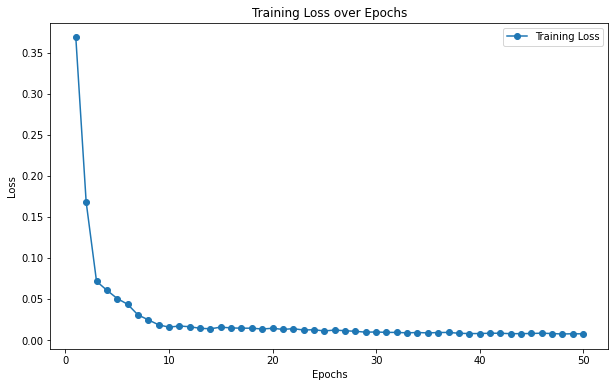

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

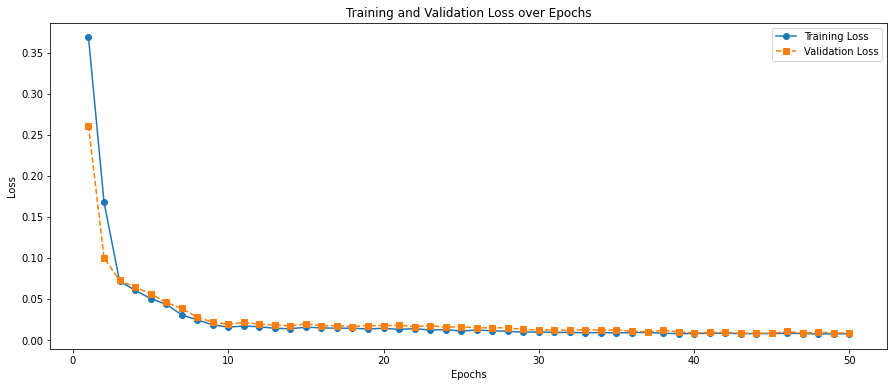

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [8]:
from tensorflow.keras.models import load_model
model1 = load_model('Ross_model/')

In [9]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 17ms/step


In [10]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.07924809889064187
MAE : 0.0636332838448716


In [11]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [12]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,2.669085e+06,2649273.174
1,3.305739e+06,3168444.759
2,3.638318e+06,3656196.531
3,3.837798e+06,3794128.369
4,3.965862e+06,3885746.442
5,4.026186e+06,3909211.179
6,3.576215e+06,3499167.351
7,2.607425e+06,2715890.297
8,1.106424e+06,1053272.694
9,7.977753e+05,368862.123


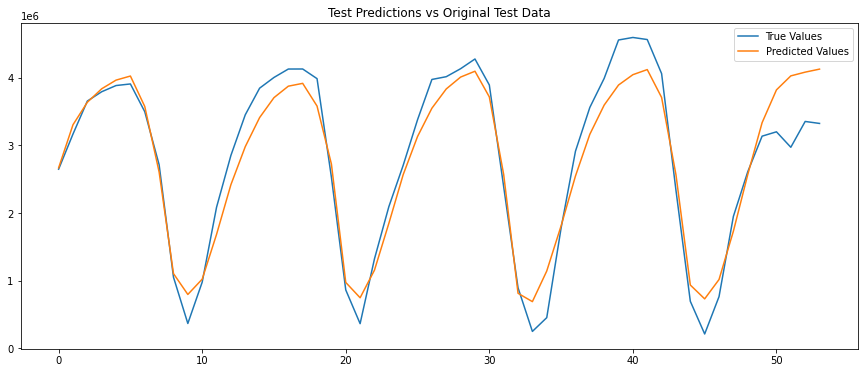

In [13]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [14]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 8ms/step


In [17]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

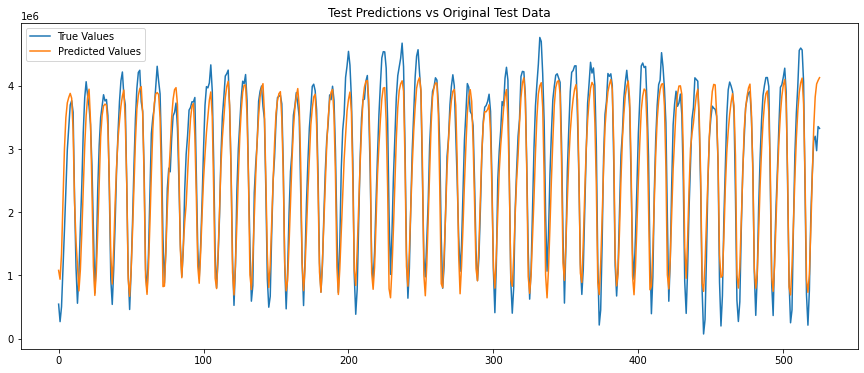

In [18]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()